#### Import Library

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import font_manager
%matplotlib inline
import os
import warnings
import glob
warnings.filterwarnings('ignore')

from kmodes.kmodes import KModes

font_fname = 'C:/Windows/Fonts/malgun.ttf'
font_family = font_manager.FontProperties(fname=font_fname).get_name()
plt.rcParams["font.family"] = font_family

#### Data Load

In [2]:
# path = './data/'
# filenames = os.listdir('./data')
data_lst = []

path = os.path.abspath('data')
all_files = glob.glob(path + "\data_*.csv")

for file in all_files:
    var_name = file[41:-4]
    globals()[f'{var_name}'] = pd.read_csv(file, low_memory=False)
    globals()[f'{var_name}'].drop(['Self_conf'], axis=1, inplace=True)
    data_lst.append(globals()[f'{var_name}'])

In [3]:
data = data_08

In [292]:
def to_int(data):
    result = data.copy()
    result['Gender'] = np.where(result['Gender'] == '남성', 0, 1)
    result['Job']  = np.where(result['Job'] == '비경활', 0,
                    np.where(result['Job'].isin(['은퇴','부분은퇴']), 1,
                            np.where(result['Job'] == '임금_고숙련', 4,
                                np.where(result['Job'] == '임금_중숙련', 3,
                                    np.where(result['Job'] == '임금_저숙련', 2,
                                        np.where(result['Job'] == '자영업', 5, 6))))))
    result['Edu'] = np.where(result['Edu'] == '초등', 0,
                    np.where(result['Edu'] == '중등', 1,
                        np.where(result['Edu'] == '고등', 2, 3)))
    result['Health'] = np.where(result['Health'] == '활동에 제한 있음', 0,
                        np.where(result['Health'] == '그렇지 않은 편', 1, 2))
    result['Earn'] = np.where(result['Earn'] == '하', 0,
                    np.where(result['Earn'] == '중', 1, 2))
    # data['Self_conf'] = np.where(data['Self_conf'] == '하', 0,
    #                         np.where(data['Self_conf'] == '중', 1, 2))
    return result

## Clustering

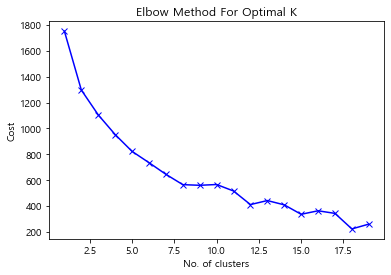

In [257]:
K = range(1, 20)
cost = []
for num_clusters in list(K):
    kmode = KModes(n_clusters=num_clusters, init = 'random', random_state=2022)
    kmode.fit_predict(data.drop(['Gender'], axis=1))
    cost.append(kmode.cost_)

plt.plot(K, cost, 'bx-')
plt.xlabel('No. of clusters')
plt.ylabel('Cost')
plt.title('Elbow Method For Optimal K')
plt.show()

#### Silhouette Score

In [258]:
from sklearn.metrics import silhouette_samples, silhouette_score
kmodes = KModes(n_clusters=6, init='random', random_state=2022)
kmodes.fit(data.drop(['Gender'], axis=1))

KModes(init='random', n_clusters=6)

In [259]:
kmodes.labels_

array([3, 3, 0, ..., 4, 0, 1], dtype=uint16)

In [260]:
def visualize_silhouette(cluster_lists, X_features): 
    from kmodes.kmodes import KModes
    from sklearn.metrics import silhouette_samples, silhouette_score

    import matplotlib.pyplot as plt
    import matplotlib.cm as cm
    import math

    # 입력값으로 클러스터링 갯수들을 리스트로 받아서, 각 갯수별로 클러스터링을 적용하고 실루엣 개수를 구함
    n_cols = len(cluster_lists)

    # plt.subplots()으로 리스트에 기재된 클러스터링 수만큼의 sub figures를 가지는 axs 생성 
    fig, axs = plt.subplots(figsize=(4*n_cols, 4), nrows=1, ncols=n_cols)

    # 리스트에 기재된 클러스터링 갯수들을 차례로 iteration 수행하면서 실루엣 개수 시각화
    for ind, n_cluster in enumerate(cluster_lists):

        # KMeans 클러스터링 수행하고, 실루엣 스코어와 개별 데이터의 실루엣 값 계산. 
        clusterer = KModes(n_clusters = n_cluster, max_iter=500, random_state=2022)
        cluster_labels = clusterer.fit_predict(X_features)

        sil_avg = silhouette_score(X_features, cluster_labels)
        sil_values = silhouette_samples(X_features, cluster_labels)

        y_lower = 10
        axs[ind].set_title('Number of Cluster : '+ str(n_cluster)+'\n' \
                          'Silhouette Score :' + str(round(sil_avg,3)) )
        axs[ind].set_xlabel("The silhouette coefficient values")
        axs[ind].set_ylabel("Cluster label")
        axs[ind].set_xlim([-0.1, 1])
        axs[ind].set_ylim([0, len(X_features) + (n_cluster + 1) * 10])
        axs[ind].set_yticks([])  # Clear the yaxis labels / ticks
        axs[ind].set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])

        # 클러스터링 갯수별로 fill_betweenx( )형태의 막대 그래프 표현. 
        for i in range(n_cluster):
            ith_cluster_sil_values = sil_values[cluster_labels==i]
            ith_cluster_sil_values.sort()

            size_cluster_i = ith_cluster_sil_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / n_cluster)
            axs[ind].fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_sil_values, \
                                facecolor=color, edgecolor=color, alpha=0.7)
            axs[ind].text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
            y_lower = y_upper + 10

        axs[ind].axvline(x=sil_avg, color="red", linestyle="--")

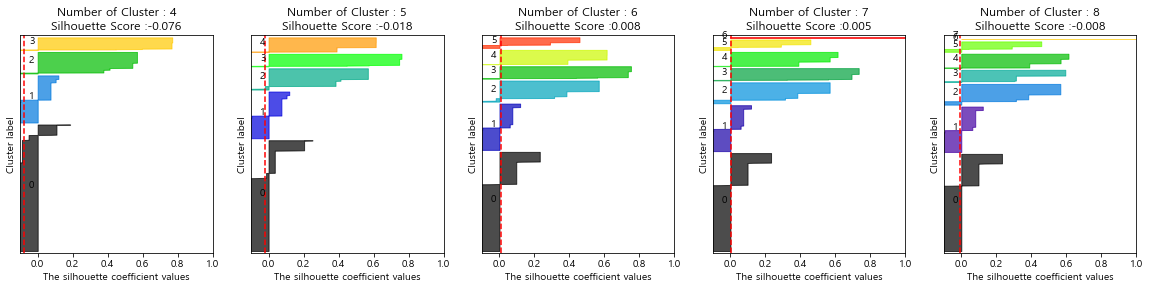

In [261]:
int_data = to_int(data)
visualize_silhouette([4,5,6,7,8], int_data.drop(['Gender'], axis=1))

In [293]:
kmode = KModes(n_clusters=6, init='random', random_state=2022)
kmode.fit_predict(data.drop(['Gender'], axis=1))
data['Cluster'] = kmode.labels_

#### Data Analysis

In [294]:
Static = data.drop(['Cluster'], axis=1)
Static.Gender.value_counts(normalize=True)

여성    0.593085
남성    0.406915
Name: Gender, dtype: float64

In [295]:
Male = Static[Static['Gender']=='남성']
Female = Static[Static['Gender']=='여성']

In [296]:
print('Total: \n', Static.Job.value_counts(normalize=True))
print('Male: \n',Male.Job.value_counts(normalize=True))
print('Female: \n', Female.Job.value_counts(normalize=True))

Total: 
 비경활        0.407801
임금_저숙련     0.296099
임금_중숙련     0.217199
임금_고숙련     0.068262
은퇴         0.008865
무급가족종사자    0.000887
자영업        0.000887
Name: Job, dtype: float64
Male: 
 임금_중숙련     0.363834
임금_저숙련     0.263617
비경활        0.233115
임금_고숙련     0.124183
은퇴         0.010893
무급가족종사자    0.002179
자영업        0.002179
Name: Job, dtype: float64
Female: 
 비경활       0.527653
임금_저숙련    0.318386
임금_중숙련    0.116592
임금_고숙련    0.029895
은퇴        0.007474
Name: Job, dtype: float64


In [297]:
print('Total: \n', Static.Edu.value_counts(normalize=True))
print('Male: \n',Male.Edu.value_counts(normalize=True))
print('Female: \n', Female.Edu.value_counts(normalize=True))

Total: 
 중등        0.515071
초등        0.179965
고등        0.175532
대학교 이상    0.129433
Name: Edu, dtype: float64
Male: 
 중등        0.505447
초등        0.281046
고등        0.132898
대학교 이상    0.080610
Name: Edu, dtype: float64
Female: 
 중등        0.521674
고등        0.204783
대학교 이상    0.162930
초등        0.110613
Name: Edu, dtype: float64


In [298]:
print('Total: \n', Static.Health.value_counts(normalize=True))
print('Male: \n',Male.Health.value_counts(normalize=True))
print('Female: \n', Female.Health.value_counts(normalize=True))

Total: 
 전혀 지장없음      0.526596
그렇지 않은 편     0.465426
활동에 제한 있음    0.007979
Name: Health, dtype: float64
Male: 
 전혀 지장없음      0.511983
그렇지 않은 편     0.474946
활동에 제한 있음    0.013072
Name: Health, dtype: float64
Female: 
 전혀 지장없음      0.536622
그렇지 않은 편     0.458894
활동에 제한 있음    0.004484
Name: Health, dtype: float64


In [299]:
print('Total: \n', Static.Earn.value_counts(normalize=True))
print('Male: \n',Male.Earn.value_counts(normalize=True))
print('Female: \n', Female.Earn.value_counts(normalize=True))

Total: 
 상    0.578014
중    0.312057
하    0.109929
Name: Earn, dtype: float64
Male: 
 상    0.623094
중    0.283224
하    0.093682
Name: Earn, dtype: float64
Female: 
 상    0.547085
중    0.331839
하    0.121076
Name: Earn, dtype: float64


#### For Pre New Elder

In [54]:
pre = pd.read_csv('./data/Lt08.csv')
pre

,pid,hhid,HHID20,CID20,ed,w08wgt_c,w08wgt_p,w01,w02,w03,...,w08G014,w08G026,w08G027,w08G028,w08G029,w08G030,w08G031,w08G032,w08Ba001,w08Ba002
0,11,1,10000000,11,833,1600.303883,2189.837105,1,1.0,1.0,...,NaN,80,60,NaN,60.0,70,4,20,1.0,NaN
1,21,2,20000000,21,833,3180.749884,3919.849664,1,1.0,1.0,...,NaN,50,40,60.0,50.0,30,5,10,1.0,NaN
2,22,2,20000000,21,833,4525.161503,5994.598161,1,1.0,1.0,...,NaN,60,50,60.0,NaN,60,4,20,1.0,NaN
3,41,4,40000000,41,833,1239.297401,1695.840060,1,1.0,1.0,...,NaN,70,60,60.0,70.0,60,5,10,1.0,NaN
4,42,4,40000000,41,833,1069.049862,1207.745056,1,1.0,1.0,...,NaN,60,60,70.0,NaN,60,6,5,1.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5712,61671,6167,61670000000,61671,672,1962.325562,2019.482662,1,1.0,1.0,...,NaN,30,30,NaN,80.0,50,5,5,1.0,NaN
5713,61681,6168,61680000000,61681,672,1439.828558,1481.766769,1,1.0,1.0,...,NaN,20,30,NaN,50.0,50,6,2,1.0,NaN
5714,61691,6169,61690000000,61691,672,1440.165656,1482.113687,1,1.0,1.0,...,NaN,50,50,NaN,80.0,50,5,2,1.0,NaN
5715,61701,6170,61700000000,61701,672,822.192069,1432.032181,1,1.0,1.0,...,NaN,50,50,NaN,80.0,80,4,5,1.0,NaN


In [55]:
def new_preprocessing(data, period):
    # data = data[(data[f'w{period}A002_age'] >= 60) & (data[f'w{period}A002_age'] < 65)]
    data['Earn_Score'] = data[f'w{period}hhinc'] / np.sqrt(data[f'w{period}hhsize'])

    data['Earn'] = pd.qcut(data['Earn_Score'], 3, labels=['하', '중', '상'])

    index = data[data.Earn.isna()==True].index
    data.drop(index, inplace=True)

    data = data[data[f'w{period}A002y'] < 1957]
    data['Gender'] = np.where(data[f'w{period}gender1'] == 1, '남성', '여성')
    
    data['Job'] = np.where(data[f'w{period}present_ecotype'] == 3, '비경활',
                           np.where(data[f'w{period}retired'].isin([1.0, 2.0]), '은퇴',
                                np.where(data[f'w{period}job'].isin([1.0, 2.0]), '임금_고숙련',
                                        np.where(data[f'w{period}job'].isin([3.0, 6.0, 7.0, 8.0, -9.0]), '임금_중숙련',
                                                np.where(data[f'w{period}job'].isin([4.0, 5.0, 9.0]), '임금_저숙련',
                                                        np.where(data[f'w{period}emp'] == 2.0, '자영업', '무급가족종사자'))))))
    data['Edu'] = np.where(data[f'w{period}edu'] == 1, '대학교 이상',
                           np.where(data[f'w{period}edu'] == 2, '고등',
                                   np.where(data[f'w{period}edu'] == 3, '중등', '초등')))
    data['Health'] = np.where(data[f'w{period}C005'].isin([1,2]), '활동에 제한 있음',
                              np.where(data[f'w{period}C005'] == 3,'그렇지 않은 편', '전혀 지장 없음'))
                              
    data['Self_conf_Score'] = data[f'w{period}G026'] + data[f'w{period}G027'] + data[f'w{period}G028'] + data[f'w{period}G029'] + data[f'w{period}G030']

    data['Self_conf'] = np.where(data['Self_conf_Score'] > 350, '상',
                                 np.where(data['Self_conf_Score'] < 200, '하', '중'))
    
    data = data[['Gender','Job', 'Edu', 'Health', 'Earn']]
    data.reset_index(drop=True, inplace=True)
    return data

In [56]:
pre = new_preprocessing(pre, '08')

In [57]:
print('직업지위: \n', pre.Job.value_counts(normalize=True))
print('학력수준: \n', pre.Edu.value_counts(normalize=True))
print('활동제한 수준: \n', pre.Health.value_counts(normalize=True))
print('소득: \n', pre.Earn.value_counts(normalize=True))

직업지위: 
 비경활        0.761988
임금_저숙련     0.117364
임금_중숙련     0.098971
임금_고숙련     0.017736
은퇴         0.003284
무급가족종사자    0.000438
자영업        0.000219
Name: Job, dtype: float64
학력수준: 
 대학교 이상    0.488723
중등        0.246551
고등        0.177797
초등        0.086928
Name: Edu, dtype: float64
활동제한 수준: 
 그렇지 않은 편     0.467484
활동에 제한 있음    0.425881
전혀 지장 없음     0.106635
Name: Health, dtype: float64
소득: 
 하    0.393694
중    0.334355
상    0.271951
Name: Earn, dtype: float64


#### Visualization

In [304]:
for cluster in range(0, 6):
    temp = data[data['Cluster'] == cluster]
    print('Cluster Number: ', cluster)
    print('Distribution of Jobs: \n', temp.Job.value_counts(normalize=True))
    print('Distribution of Edus: \n', temp.Edu.value_counts(normalize=True))
    print('Distribution of Earns: \n', temp.Earn.value_counts(normalize=True))
    print('Distribution of Healthes: \n', temp.Health.value_counts(normalize=True))

Cluster Number:  0
Distribution of Jobs: 
 비경활       0.639286
임금_저숙련    0.210714
임금_중숙련    0.117857
임금_고숙련    0.017857
은퇴        0.014286
Name: Job, dtype: float64
Distribution of Edus: 
 중등        0.635714
대학교 이상    0.182143
고등        0.135714
초등        0.046429
Name: Edu, dtype: float64
Distribution of Earns: 
 중    0.796429
하    0.203571
Name: Earn, dtype: float64
Distribution of Healthes: 
 그렇지 않은 편     0.732143
전혀 지장없음      0.246429
활동에 제한 있음    0.021429
Name: Health, dtype: float64
Cluster Number:  1
Distribution of Jobs: 
 비경활        0.551370
임금_저숙련     0.202055
임금_중숙련     0.202055
임금_고숙련     0.030822
은퇴         0.006849
무급가족종사자    0.003425
자영업        0.003425
Name: Job, dtype: float64
Distribution of Edus: 
 중등        0.763699
고등        0.116438
초등        0.068493
대학교 이상    0.051370
Name: Edu, dtype: float64
Distribution of Earns: 
 상    1.0
Name: Earn, dtype: float64
Distribution of Healthes: 
 그렇지 않은 편     0.763699
전혀 지장없음      0.229452
활동에 제한 있음    0.006849
Name: Health, dty

In [308]:
data[data['Edu']=='대학교 이상'].Earn.value_counts()

상    59
중    55
하    32
Name: Earn, dtype: int64

In [306]:
data.columns

Index(['Gender', 'Job', 'Edu', 'Health', 'Earn', 'Cluster'], dtype='object')

In [26]:
kmode = KModes(n_clusters=6, init='random', random_state=2022)
kmode.fit_predict(data.drop(['Gender'], axis=1))
data['Cluster'] = kmode.labels_

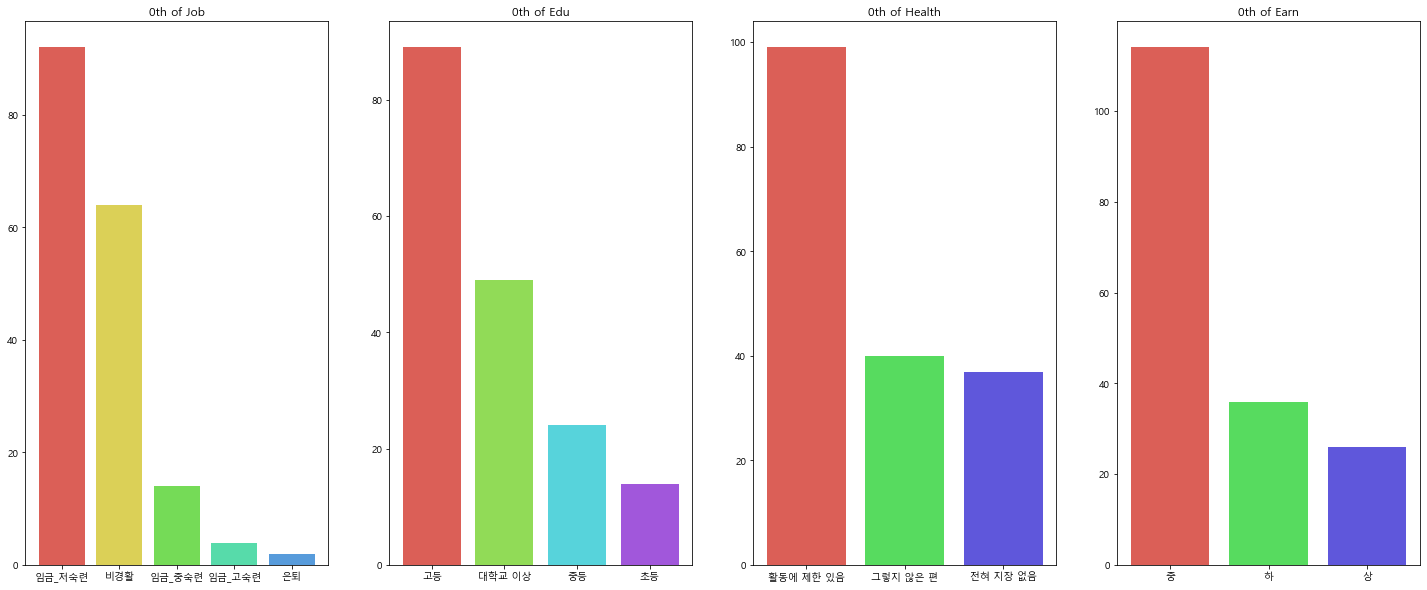

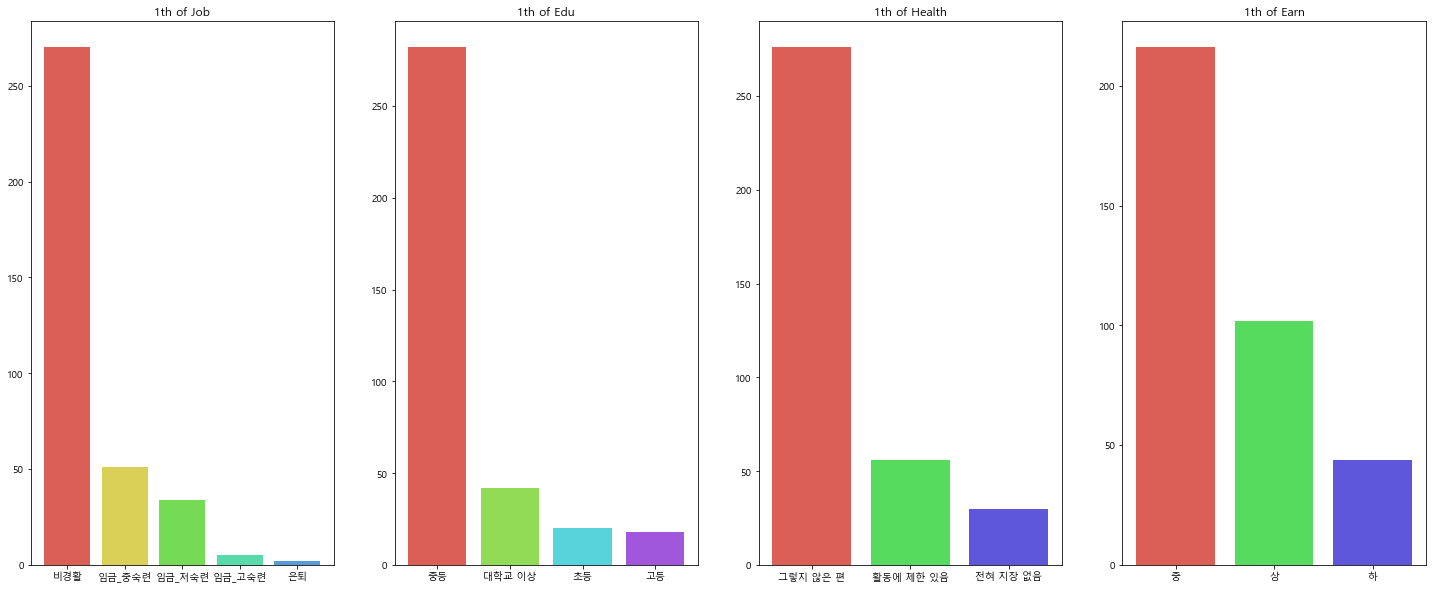

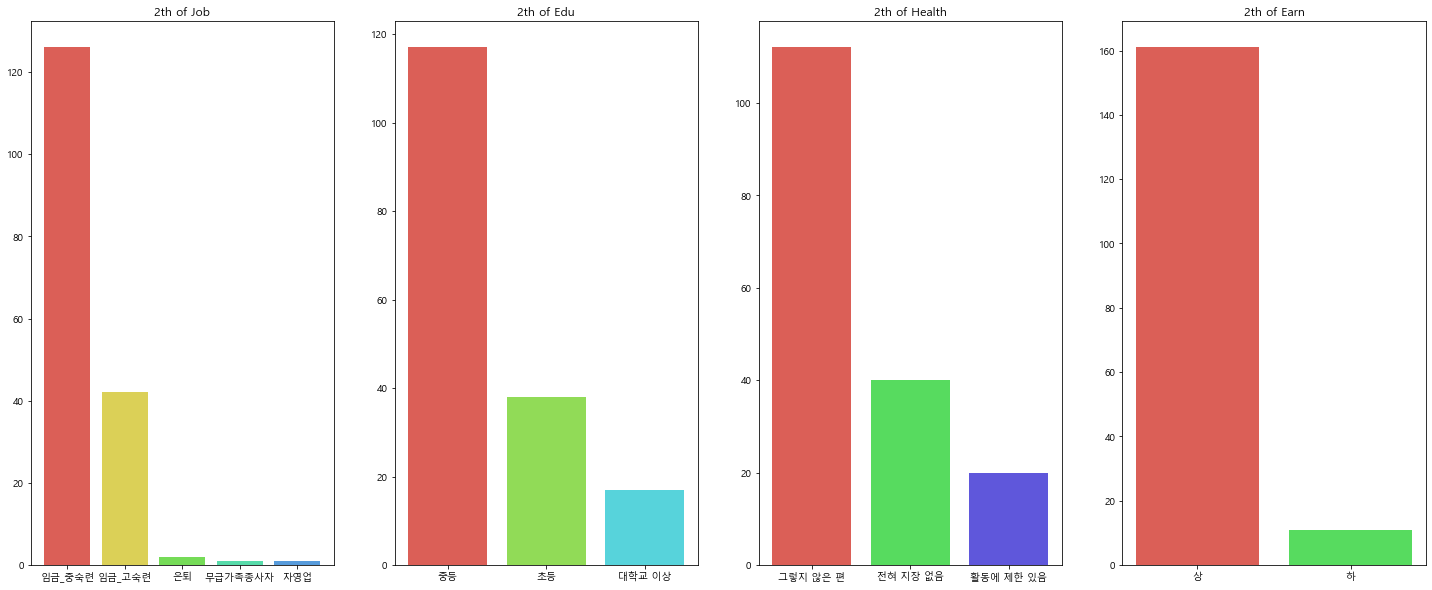

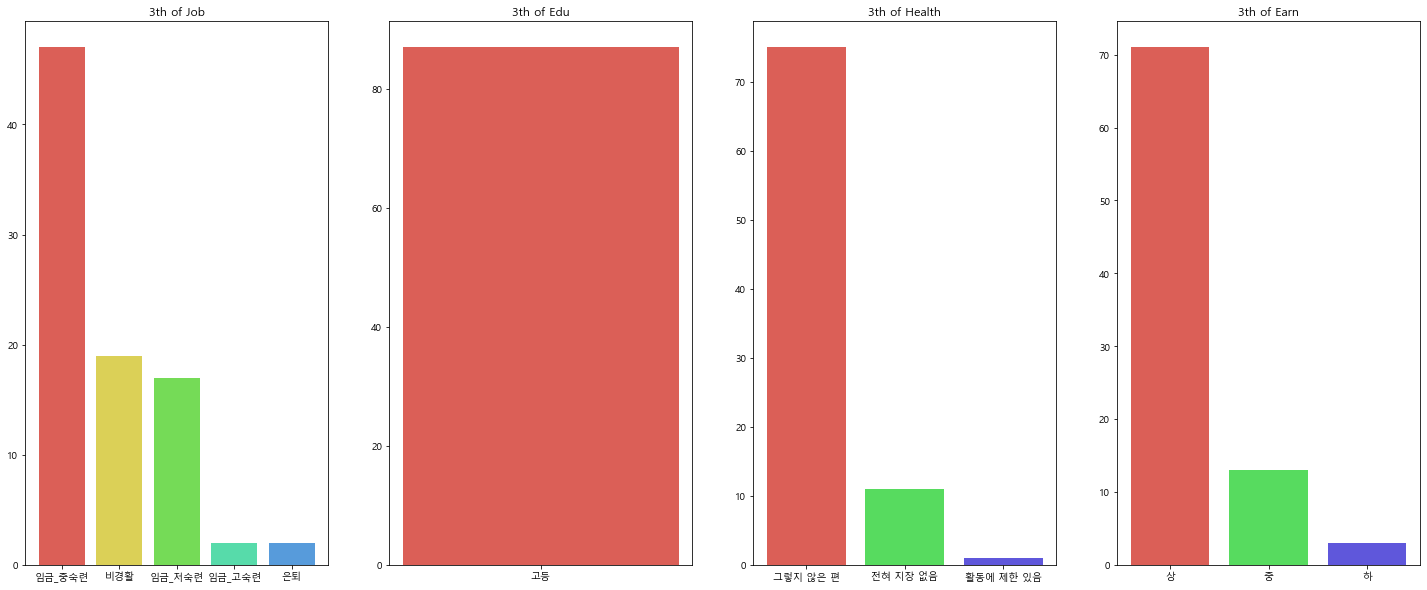

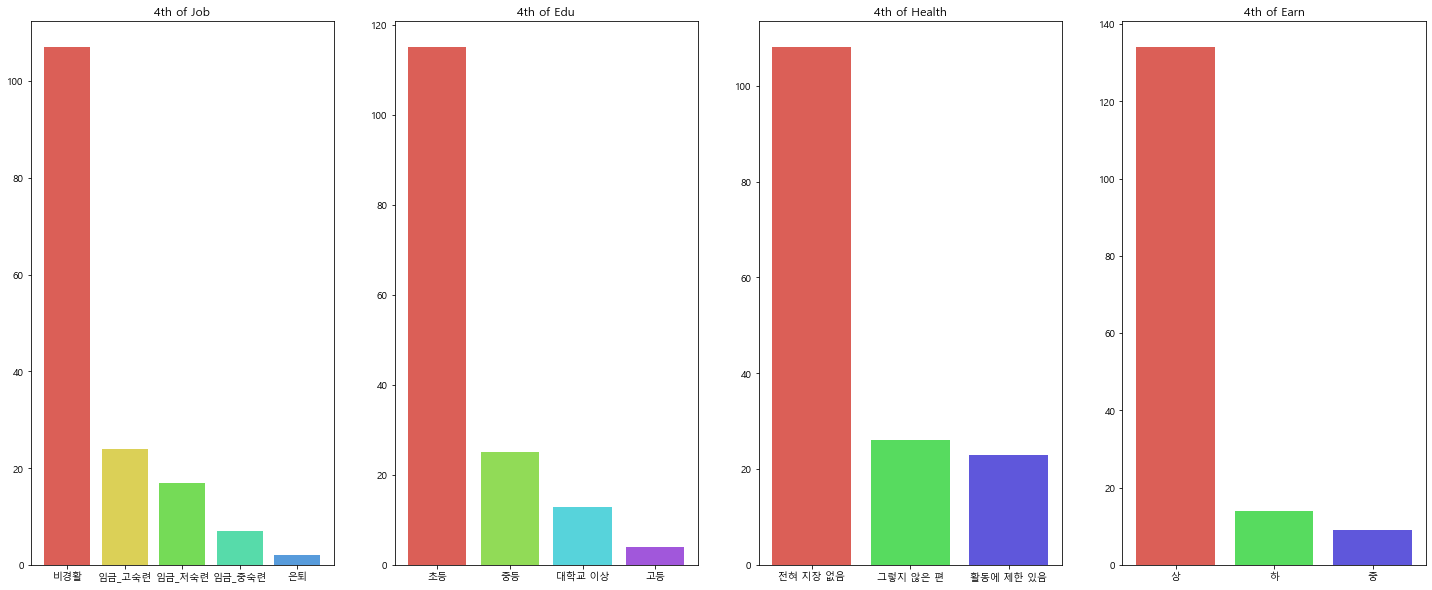

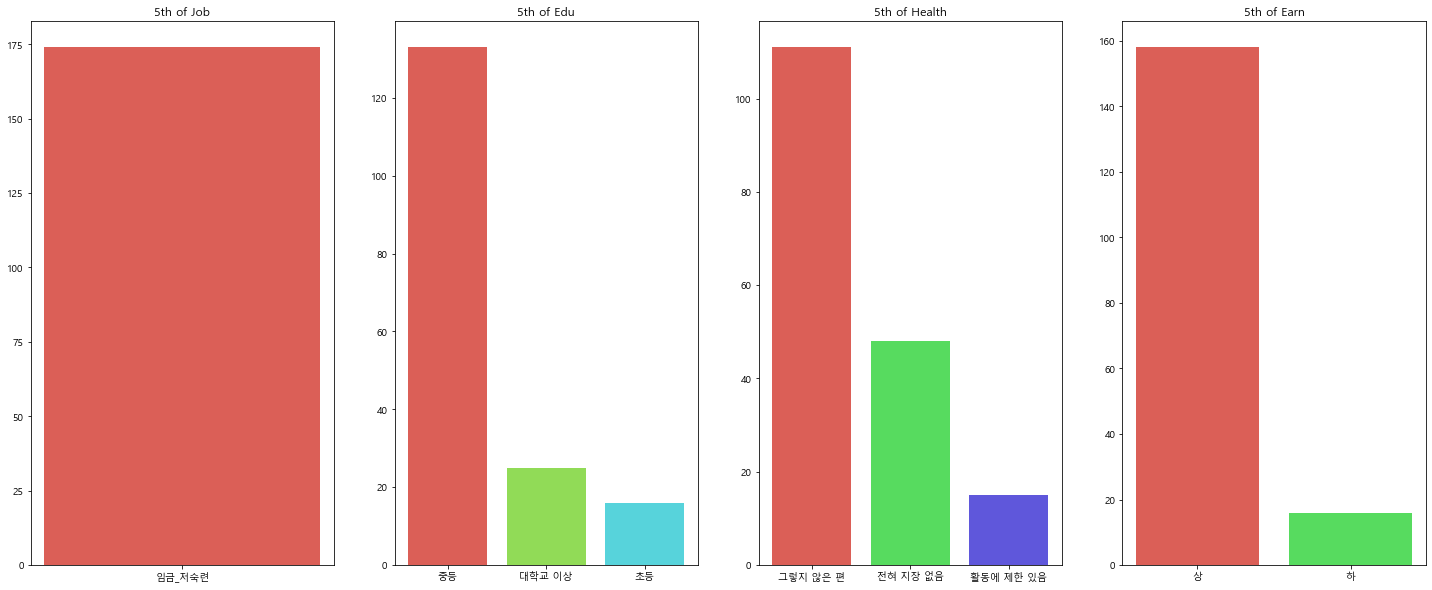

In [17]:
cols = data.drop(['Gender','Cluster'], axis=1).columns
for clus in range(0, 6):
    plt.figure(figsize=(25, 10))
    n = 1 
    for i, col in enumerate(cols):
        ax = plt.subplot(1, 4, n)
        colors = sns.color_palette('hls',len(data[col].value_counts()))
        temp = data[data['Cluster'] == clus].drop(['Cluster'], axis=1)[col].value_counts()
        ax.bar(x = temp.index, height= temp.values, color = colors, axes= ax)
        plt.title(f'{clus}th of {col}')
        n += 1
    plt.show()

In [52]:
# 신노년세대 유형별 기술통계
cols = data.drop(['Gender','Job', 'Edu', 'Cluster'], axis=1).columns
clus = data.Cluster.unique()
for clu in clus:
    temp = data[data['Cluster']==clu]
    print(f'Size of {clu}th Cluster:', np.round(len(temp)/len(data),2))
    for col in cols:
        print(f'{clu}th Cluster of {col} ratio')
        print(temp[col].value_counts(normalize=True))
    print('-----------------------------------------------------------')

Size of 2th Cluster: 0.15
2th Cluster of Health ratio
그렇지 않은 편     0.651163
전혀 지장 없음     0.232558
활동에 제한 있음    0.116279
Name: Health, dtype: float64
2th Cluster of Earn ratio
상    0.936047
하    0.063953
Name: Earn, dtype: float64
-----------------------------------------------------------
Size of 1th Cluster: 0.32
1th Cluster of Health ratio
그렇지 않은 편     0.762431
활동에 제한 있음    0.154696
전혀 지장 없음     0.082873
Name: Health, dtype: float64
1th Cluster of Earn ratio
중    0.596685
상    0.281768
하    0.121547
Name: Earn, dtype: float64
-----------------------------------------------------------
Size of 4th Cluster: 0.14
4th Cluster of Health ratio
전혀 지장 없음     0.687898
그렇지 않은 편     0.165605
활동에 제한 있음    0.146497
Name: Health, dtype: float64
4th Cluster of Earn ratio
상    0.853503
하    0.089172
중    0.057325
Name: Earn, dtype: float64
-----------------------------------------------------------
Size of 5th Cluster: 0.15
5th Cluster of Health ratio
그렇지 않은 편     0.637931
전혀 지장 없음     0.275862
활동에 